In [1]:
import yfinance as yf
yf.pdr_override()
import pandas_datareader.data as web
import datetime
import numpy as np
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import tensorflow as tf
from arch import arch_model
from arch.univariate import EGARCH
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

[*********************100%***********************]  1 of 1 completed


Text(0.5, 1.0, 'SPY Returns')

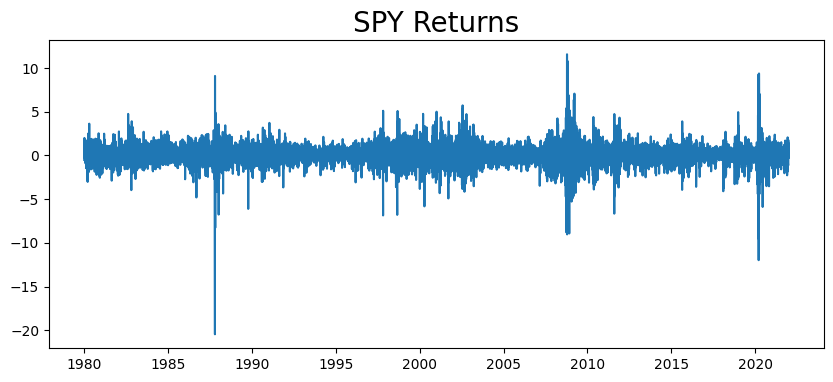

In [2]:
SPY = web.get_data_yahoo("^GSPC", start = "1980-01-01", end = "2022-01-01")

returns = 100 * SPY.Close.pct_change().dropna()
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.title('SPY Returns', fontsize=20)

In [3]:
(len(returns))

10591

In [ ]:
2116, 8464

In [4]:
split_time_1 = 8464
split_time_2 = 10580

train_idx = returns.index[:split_time_1]
val_idx = returns.index[split_time_1:split_time_2]
test_idx = returns.index[split_time_2:]

In [5]:
returns.index[8464]
ts_train = returns[train_idx]
ts_val = returns[val_idx]
ts_test = returns[test_idx]

In [9]:
len(vol_train)

8464

In [7]:
def get_volatility(ts, window=None):
    """
    Get the volatility of a time series as the standard deviation of an index's
    price returns using cumulative moving average or rolling window average
    depending on whether or not window parameter is specified
    """
    if window:
        ma = ts.rolling(window).mean()
    else:
        ma = ts.expanding().mean()
    output = ((ts - ma)**2)**.5

    return output

In [8]:
WINDOW_SIZE = 14

# CALCULATING VOLATILITY ON A 14 DAY PERIOD
vols = get_volatility(returns, window=WINDOW_SIZE)

vol_train = vols[train_idx]
vol_val = vols[val_idx]
vol_test = vols[test_idx]


In [10]:
vol_train = vol_train.dropna()
vol_train

Date
1980-01-22    0.907472
1980-01-23    1.189529
1980-01-24    0.240187
1980-01-25    0.523430
1980-01-28    0.712324
                ...   
2013-07-17    0.062157
2013-07-18    0.172070
2013-07-19    0.212362
2013-07-22    0.145988
2013-07-23    0.525148
Name: Close, Length: 8451, dtype: float64

In [10]:
ma = returns.rolling(WINDOW_SIZE).mean()
ewma = returns.ewm(span=WINDOW_SIZE).mean()

Text(0.5, 1.0, 'SPY Volatility')

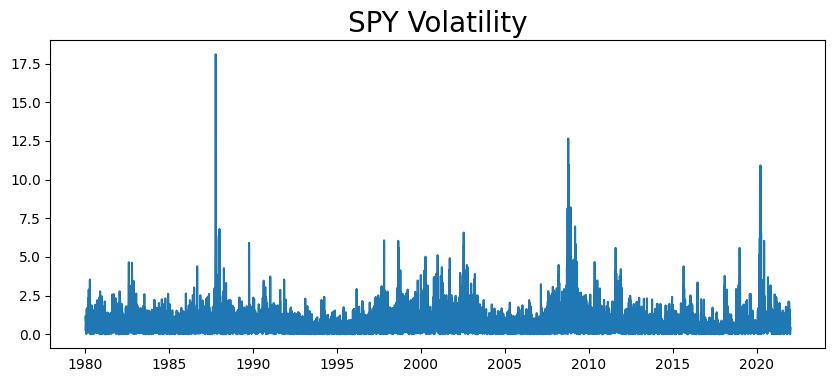

In [13]:
plt.figure(figsize=(10,4))
plt.plot(vols)
plt.title('SPY Volatility', fontsize=20)

In [11]:
mean_train_vol = vol_train.mean()
mean_train_vol

0.7428960986512639

In [311]:
def RMSE(y_true, y_pred):
    """
    Compute Root Mean Squared Error between 2 arrays
    """
    output = np.sqrt(mse(y_true, y_pred))
    return output
def smape(a, f):
    return 100/len(a) * np.sum(np.abs(f-a) / (np.abs(a) + np.abs(f)))

In [206]:
bic_garch = []

for p in range(1, 5):
    for q in range(1, 5):
         garch = arch_model(returns, mean='zero',vol='GARCH', p=p, o=1, q=q)\
             .fit(disp='off')
         bic_garch.append(garch.bic)
         if garch.bic == np.min(bic_garch):
             best_param = p, q
garch = arch_model(returns, mean='zero', vol='GARCH',
                p=best_param[0], o=0, q=best_param[1])\
     .fit(disp='off')
print(garch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -14130.8
Distribution:                  Normal   AIC:                           28271.6
Method:            Maximum Likelihood   BIC:                           28308.0
                                        No. Observations:                10591
Date:                Sat, Jan 14 2023   Df Residuals:                    10591
Time:                        14:12:08   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0194  6.370e-03      3.041  2.361e-03 

In [97]:
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(ts_val)):

    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    ts_train = returns[:idx]

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(ts_train, vol='GARCH', p=1, q=1,
                       mean='constant', dist='normal')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION
    pred = (model_fit.forecast(horizon=2, reindex=False).variance.values[0][0])**.5

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

In [116]:
rolling_predictions = pd.Series(rolling_forecasts, index=ts_val.index)
RMSE(vol_val, rolling_predictions)
mae(vol_val, rolling_predictions)
smape(vol_val, rolling_predictions)
0.664335437795502, 0.4896531587072615, 38.660947675740175

(0.664335437795502, 0.4896531587072615, 38.660947675740175)

In [125]:
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(ts_val)):

    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    ts_train = returns[:idx]

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(ts_train, vol='EGARCH', p=2, q=2,
                       mean='constant', dist='normal')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION
    pred = (model_fit.forecast(horizon=1, reindex=False).variance.values[0][0])**.5

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

In [126]:
rolling_predictions = pd.Series(rolling_forecasts, index=ts_val.index)

smape(vol_val, rolling_predictions)

38.35620065692069

In [127]:
RMSE(vol_val, rolling_predictions)



0.6545405046003374

In [128]:
mae(vol_val, rolling_predictions)



0.4808563189191814

In [207]:
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(ts_val)):

    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    ts_train = returns[:idx]

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(ts_train, vol='GARCH', p=3,o=1,q=1,
                       mean='constant', dist='normal')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION
    pred = (model_fit.forecast(horizon=1, reindex=False).variance.values[0][0])**.5

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

In [208]:
rolling_predictions = pd.Series(rolling_forecasts, index=ts_val.index)
print(RMSE(vol_val, rolling_predictions))
print(mae(vol_val, rolling_predictions))
print(smape(vol_val, rolling_predictions))

0.6507227762156593
0.4791664677596539
38.25690654335203


In [122]:
RMSE(vol_val, rolling_predictions)


0.6463317268861533

In [123]:
mae(vol_val, rolling_predictions)

0.4782931061038575

In [115]:
smape(vol_val, rolling_predictions)

38.660947675740175

In [ ]:
0.664335437795502, 0.4896531587072615, 77.32189535148035

In [265]:
import tensorflow as tf
from tensorflow.python.keras.models import Sequential, load_model
from tensorflow.python.keras.layers.core import Dense
from tensorflow.python.keras.layers.recurrent import LSTM
from tensorflow.python.keras import optimizers
from tensorflow.python.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
import seaborn as sns
from keras.optimizers import adam_v2


In [48]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [184]:
def viz_train_val_metrics(model_hist):
    with sns.axes_style("white"):
        fig, ax = plt.subplots(figsize=(15,6))

        # PLOT MSE - LEFT Y-AXIS
        # TRAINING
        ln11 = ax.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['loss'], color='lightblue',
                    label='Training MSE', lw=2)
        # VALIDATION
        ln12 = ax.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['val_loss'], color='darkblue',
                    label='Validation MSE', lw=2)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('MSE')

        # PLOT RMSE - RIGHT Y-AXIS
        ax2 = ax.twinx()
        ln21 = ax2.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['RMSE'], color='pink', lw=2,
                    label='Training RMSE')
        ln22 = ax2.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['val_mse'], color='red', lw=2,
                    label='Validation MSE')
        ax2.set_ylabel('MSE')

        # COMBINING LALBELS FOR 4 LINES INTO 1 LEGEND
        lns = ln11 + ln12 + ln21 + ln22
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc='best')

        ax.set_title('Training vs. Validation Learning Curves')
        plt.show();

In [224]:
np.array(ts_train).shape

(10580,)

In [242]:
ts_train

Date
1980-01-03   -0.510591
1980-01-04    1.235502
1980-01-07    0.272250
1980-01-08    2.003557
1980-01-09    0.091791
                ...   
2021-12-09   -0.718108
2021-12-10    0.954907
2021-12-13   -0.913617
2021-12-14   -0.747068
2021-12-15    1.634846
Name: Close, Length: 10580, dtype: float64

In [347]:
window_size = 14
batch_size = 10
shuffle_buffer_size = 1000



opt = tf.keras.optimizers.SGD(learning_rate=1e-9)

dataset = windowed_dataset(vol_train, window_size, batch_size, shuffle_buffer_size)

In [348]:
val_dataset = windowed_dataset(vol_val, window_size, 10, 1000)

In [275]:
from keras.optimizers import adam_v2


In [355]:
model = Sequential()

model.add(Dense(1, input_shape=(window_size, ), activation="tanh"))
# model.add(Dense(4, activation="sigmoid"))
model.add(Dense(1))
opt = adam_v2.Adam(learning_rate=0.01, decay=1e-6)



model.compile(loss='mse', optimizer='adam', metrics=[tf.keras.metrics.MeanSquaredError()])

#     tf.keras.layers.Dense(1, input_shape=[window_size], activation='tanh'),
#     tf.keras.layers.Dense(1, activation='tanh'),
#     tf.keras.layers.Dense(1)
# lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-8 * (10**(epoch/20)))
# model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = 'mse') 

model.summary()

# history = model.fit(ts_train, epochs=10)


Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_146 (Dense)            (None, 1)                 15        
_________________________________________________________________
dense_147 (Dense)            (None, 1)                 2         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


In [356]:
history = model.fit(dataset, epochs=150, validation_data = val_dataset, verbose=1)

Epoch 1/150
844/844 [==============================] - 1s 531us/step - loss: 0.7857 - mean_squared_error: 0.8447 - val_loss: 0.6604 - val_mean_squared_error: 0.7643
Epoch 2/150
844/844 [==============================] - 0s 497us/step - loss: 0.6361 - mean_squared_error: 0.6953 - val_loss: 0.6539 - val_mean_squared_error: 0.6976
Epoch 3/150
844/844 [==============================] - 0s 502us/step - loss: 0.6249 - mean_squared_error: 0.6728 - val_loss: 0.6186 - val_mean_squared_error: 0.6755
Epoch 4/150
844/844 [==============================] - 0s 514us/step - loss: 0.6005 - mean_squared_error: 0.6576 - val_loss: 0.5785 - val_mean_squared_error: 0.6536
Epoch 5/150
844/844 [==============================] - 0s 495us/step - loss: 0.5749 - mean_squared_error: 0.6410 - val_loss: 0.5623 - val_mean_squared_error: 0.6391
Epoch 6/150
844/844 [==============================] - 0s 507us/step - loss: 0.5614 - mean_squared_error: 0.6272 - val_loss: 0.5421 - val_mean_squared_error: 0.6250
Epoch 7/15

844/844 [==============================] - 0s 489us/step - loss: 0.5296 - mean_squared_error: 0.5269 - val_loss: 0.4665 - val_mean_squared_error: 0.5270
Epoch 100/150
844/844 [==============================] - 0s 488us/step - loss: 0.5294 - mean_squared_error: 0.5268 - val_loss: 0.4717 - val_mean_squared_error: 0.5269
Epoch 101/150
844/844 [==============================] - 0s 495us/step - loss: 0.5278 - mean_squared_error: 0.5267 - val_loss: 0.4649 - val_mean_squared_error: 0.5268
Epoch 102/150
844/844 [==============================] - 1s 546us/step - loss: 0.5289 - mean_squared_error: 0.5265 - val_loss: 0.4644 - val_mean_squared_error: 0.5268
Epoch 103/150
844/844 [==============================] - 0s 497us/step - loss: 0.5296 - mean_squared_error: 0.5265 - val_loss: 0.4700 - val_mean_squared_error: 0.5267
Epoch 104/150
844/844 [==============================] - 1s 621us/step - loss: 0.5273 - mean_squared_error: 0.5264 - val_loss: 0.4656 - val_mean_squared_error: 0.5265
Epoch 105/15

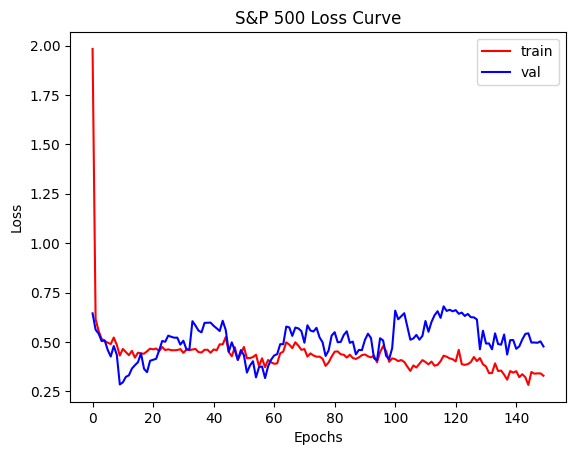

In [298]:
def plot_error(train_loss, val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title("S&P 500 Loss Curve")
    plt.legend(['train', 'val'],loc = 'upper right')
    #plt.savefig('Thesis Document\\KF5 Figures\\NN (5,1,1)\\' + sector + '\\' + sector + ' - NN(5,1,1) Train vs. Validation.png')
    plt.show()

train_error = history.history['loss']
val_error = history.history['val_loss']
plot_error(train_error, val_error)

In [ ]:
trainPredict = model.predict(ts_train)





In [376]:
model = Sequential()

model.add(Dense(1, input_shape=(window_size, ), activation="tanh"))
# model.add(Dense(4, activation="sigmoid"))
model.add(Dense(1))
opt = adam_v2.Adam(learning_rate=0.01, decay=1e-6)



model.compile(loss='mae', optimizer='adam', metrics=[tf.keras.metrics.MeanSquaredError()])

#     tf.keras.layers.Dense(1, input_shape=[window_size], activation='tanh'),
#     tf.keras.layers.Dense(1, activation='tanh'),
#     tf.keras.layers.Dense(1)
# lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-8 * (10**(epoch/20)))
# model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = 'mse') 

model.summary()

# history = model.fit(ts_train, epochs=10)



Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_156 (Dense)            (None, 1)                 15        
_________________________________________________________________
dense_157 (Dense)            (None, 1)                 2         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


In [377]:
dataset = windowed_dataset(vol_train, window_size, batch_size, shuffle_buffer_size)
val_dataset = windowed_dataset(vol_val, window_size, 10, 1000)

In [378]:
history1 = model.fit(dataset, epochs=150, validation_data = val_dataset, verbose=1)

Epoch 1/150
844/844 [==============================] - 1s 554us/step - loss: 0.5215 - mean_squared_error: 0.7429 - val_loss: 0.4597 - val_mean_squared_error: 0.7412
Epoch 2/150
844/844 [==============================] - 0s 495us/step - loss: 0.4923 - mean_squared_error: 0.6994 - val_loss: 0.4533 - val_mean_squared_error: 0.7121
Epoch 3/150
844/844 [==============================] - 0s 501us/step - loss: 0.4894 - mean_squared_error: 0.6880 - val_loss: 0.4459 - val_mean_squared_error: 0.6969
Epoch 4/150
844/844 [==============================] - 0s 514us/step - loss: 0.4856 - mean_squared_error: 0.6833 - val_loss: 0.4400 - val_mean_squared_error: 0.6891
Epoch 5/150
844/844 [==============================] - 0s 497us/step - loss: 0.4812 - mean_squared_error: 0.6753 - val_loss: 0.4337 - val_mean_squared_error: 0.6802
Epoch 6/150
844/844 [==============================] - 0s 487us/step - loss: 0.4774 - mean_squared_error: 0.6695 - val_loss: 0.4301 - val_mean_squared_error: 0.6692
Epoch 7/15

KeyboardInterrupt: 

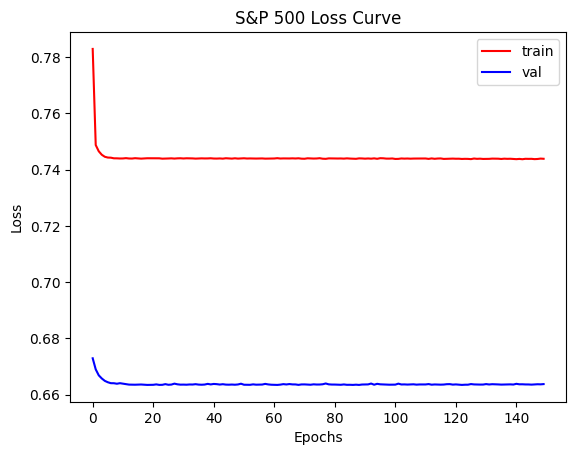

In [325]:
train_error1 = history1.history['loss']
val_error1 = history1.history['val_loss']
plot_error(train_error1, val_error1)

In [315]:
trainPredict = model.predict(ts_train)

trainPredict = trainPredict.reshape((trainPredict.shape[0], trainPredict.shape[2]))

trainPredict = scaler.inverse_transform(trainPredict)
# trainY = scaler.inverse_transform([trainY])


trainMAE = mean_absolute_error(ts_train[0], trainPredict[:,0])
print('Train MAE: %.7f' % (trainMAE))
trainScore = math.sqrt(mean_squared_error(ts_train[0], trainPredict[:,0]))
trainMSE = trainScore**2
print('Train MSE: %.7f' % (trainMSE))
print('Train RMSE: %.7f' % (trainScore))



ValueError: in user code:


    ValueError: Input 0 of layer sequential_58 is incompatible with the layer: expected axis -1 of input shape to have value 14 but received input with shape (None, 1)


In [246]:
forecast = []
idx = returns.index

for t in range(len(vol_val)):
    forecast.append(model.predict(returns[idx[t]:idx[t+window_size-1]].values[np.newaxis]))
    
forecast = forecast[-len(x_val):]

results = np.array(forecast)[:, 0, 0]

NameError: name 'x_val' is not defined

nan

In [337]:
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(ts_val)):

    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    ts_train = returns[:idx]

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(ts_train, vol='GARCH', p=2, q=2,
                       mean='constant', dist='normal')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION
    pred = (model_fit.forecast(horizon=1, reindex=False).variance.values[0][0])**.5

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

In [364]:
dataset = windowed_dataset(rolling_forecasts, window_size, batch_size, shuffle_buffer_size)
val_dataset = windowed_dataset(rolling_forecasts, window_size, 10, 1000)

In [371]:
model = Sequential()

model.add(Dense(1, input_shape=(window_size, ), activation="tanh"))
# model.add(Dense(4, activation="sigmoid"))
model.add(Dense(1))
opt = adam_v2.Adam(learning_rate=0.01, decay=1e-6)



model.compile(loss='mae', optimizer='adam', metrics=[tf.keras.metrics.MeanSquaredError()])



model.summary()



Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_154 (Dense)            (None, 1)                 15        
_________________________________________________________________
dense_155 (Dense)            (None, 1)                 2         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


In [372]:
history2 = model.fit(dataset, epochs=150, validation_data = val_dataset, verbose=1)

Epoch 1/150
211/211 [==============================] - 0s 1ms/step - loss: 0.1914 - mean_squared_error: 0.1378 - val_loss: 0.1775 - val_mean_squared_error: 0.2252
Epoch 2/150
211/211 [==============================] - 0s 798us/step - loss: 0.1650 - mean_squared_error: 0.2261 - val_loss: 0.1516 - val_mean_squared_error: 0.2217
Epoch 3/150
211/211 [==============================] - 0s 815us/step - loss: 0.1405 - mean_squared_error: 0.2213 - val_loss: 0.1318 - val_mean_squared_error: 0.2130
Epoch 4/150
211/211 [==============================] - 0s 804us/step - loss: 0.1233 - mean_squared_error: 0.2088 - val_loss: 0.1223 - val_mean_squared_error: 0.2034
Epoch 5/150
211/211 [==============================] - 0s 808us/step - loss: 0.1151 - mean_squared_error: 0.2013 - val_loss: 0.1144 - val_mean_squared_error: 0.1962
Epoch 6/150
211/211 [==============================] - 0s 857us/step - loss: 0.1108 - mean_squared_error: 0.1919 - val_loss: 0.1084 - val_mean_squared_error: 0.1888
Epoch 7/150


211/211 [==============================] - 0s 823us/step - loss: 0.0611 - mean_squared_error: 0.0826 - val_loss: 0.0656 - val_mean_squared_error: 0.0823
Epoch 100/150
211/211 [==============================] - 0s 775us/step - loss: 0.0610 - mean_squared_error: 0.0821 - val_loss: 0.0581 - val_mean_squared_error: 0.0819
Epoch 101/150
211/211 [==============================] - 0s 809us/step - loss: 0.0598 - mean_squared_error: 0.0817 - val_loss: 0.0582 - val_mean_squared_error: 0.0815
Epoch 102/150
211/211 [==============================] - 0s 874us/step - loss: 0.0598 - mean_squared_error: 0.0812 - val_loss: 0.0585 - val_mean_squared_error: 0.0810
Epoch 103/150
211/211 [==============================] - 0s 806us/step - loss: 0.0598 - mean_squared_error: 0.0808 - val_loss: 0.0613 - val_mean_squared_error: 0.0806
Epoch 104/150
211/211 [==============================] - 0s 832us/step - loss: 0.0611 - mean_squared_error: 0.0804 - val_loss: 0.0572 - val_mean_squared_error: 0.0802
Epoch 105/15

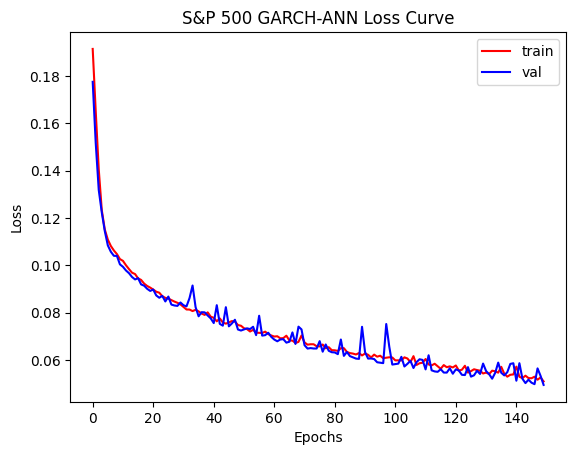

In [385]:
def plot_error(train_loss, val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title("S&P 500 GARCH-ANN Loss Curve")
    plt.legend(['train', 'val'],loc = 'upper right')
    #plt.savefig('Thesis Document\\KF5 Figures\\NN (5,1,1)\\' + sector + '\\' + sector + ' - NN(5,1,1) Train vs. Validation.png')
    plt.show()
train_error2 = history2.history['loss']
val_error2 = history2.history['val_loss']
plot_error(train_error2, val_error2)

In [387]:
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(ts_val)):

    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    ts_train = returns[:idx]

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(ts_train, vol='EGARCH', p=2, q=2,
                       mean='constant', dist='normal')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION
    pred = (model_fit.forecast(horizon=1, reindex=False).variance.values[0][0])**.5

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

In [388]:
dataset = windowed_dataset(rolling_forecasts, window_size, batch_size, shuffle_buffer_size)
val_dataset = windowed_dataset(rolling_forecasts, window_size, 10, 1000)

In [389]:
model = Sequential()

model.add(Dense(1, input_shape=(window_size, ), activation="tanh"))
# model.add(Dense(4, activation="sigmoid"))
model.add(Dense(1))
opt = adam_v2.Adam(learning_rate=0.01, decay=1e-6)



model.compile(loss='mae', optimizer='adam', metrics=[tf.keras.metrics.MeanSquaredError()])



model.summary()



Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_158 (Dense)            (None, 1)                 15        
_________________________________________________________________
dense_159 (Dense)            (None, 1)                 2         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


In [390]:
history2 = model.fit(dataset, epochs=150, validation_data = val_dataset, verbose=1)

Epoch 1/150
211/211 [==============================] - 0s 1ms/step - loss: 0.3073 - mean_squared_error: 0.2847 - val_loss: 0.2015 - val_mean_squared_error: 0.2092
Epoch 2/150
211/211 [==============================] - 0s 766us/step - loss: 0.1913 - mean_squared_error: 0.1888 - val_loss: 0.1797 - val_mean_squared_error: 0.1787
Epoch 3/150
211/211 [==============================] - 0s 792us/step - loss: 0.1701 - mean_squared_error: 0.1743 - val_loss: 0.1593 - val_mean_squared_error: 0.1691
Epoch 4/150
211/211 [==============================] - 0s 766us/step - loss: 0.1491 - mean_squared_error: 0.1646 - val_loss: 0.1379 - val_mean_squared_error: 0.1604
Epoch 5/150
211/211 [==============================] - 0s 764us/step - loss: 0.1280 - mean_squared_error: 0.1566 - val_loss: 0.1183 - val_mean_squared_error: 0.1520
Epoch 6/150
211/211 [==============================] - 0s 753us/step - loss: 0.1126 - mean_squared_error: 0.1488 - val_loss: 0.1066 - val_mean_squared_error: 0.1449
Epoch 7/150


211/211 [==============================] - 0s 759us/step - loss: 0.0585 - mean_squared_error: 0.0606 - val_loss: 0.0665 - val_mean_squared_error: 0.0604
Epoch 100/150
211/211 [==============================] - 0s 749us/step - loss: 0.0587 - mean_squared_error: 0.0603 - val_loss: 0.0568 - val_mean_squared_error: 0.0601
Epoch 101/150
211/211 [==============================] - 0s 746us/step - loss: 0.0588 - mean_squared_error: 0.0600 - val_loss: 0.0558 - val_mean_squared_error: 0.0598
Epoch 102/150
211/211 [==============================] - 0s 748us/step - loss: 0.0579 - mean_squared_error: 0.0597 - val_loss: 0.0558 - val_mean_squared_error: 0.0596
Epoch 103/150
211/211 [==============================] - 0s 736us/step - loss: 0.0572 - mean_squared_error: 0.0594 - val_loss: 0.0567 - val_mean_squared_error: 0.0593
Epoch 104/150
211/211 [==============================] - 0s 747us/step - loss: 0.0568 - mean_squared_error: 0.0591 - val_loss: 0.0549 - val_mean_squared_error: 0.0590
Epoch 105/15

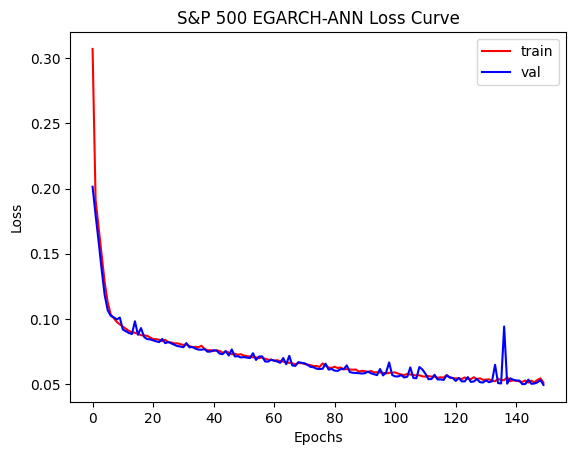

In [391]:
def plot_error(train_loss, val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title("S&P 500 EGARCH-ANN Loss Curve")
    plt.legend(['train', 'val'],loc = 'upper right')
    #plt.savefig('Thesis Document\\KF5 Figures\\NN (5,1,1)\\' + sector + '\\' + sector + ' - NN(5,1,1) Train vs. Validation.png')
    plt.show()
train_error2 = history2.history['loss']
val_error2 = history2.history['val_loss']
plot_error(train_error2, val_error2)

In [397]:
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(ts_val)):

    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    ts_train = returns[:idx]

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(ts_train, p=1,o=1, q=1,
                       mean='constant', dist='normal')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION
    pred = (model_fit.forecast(horizon=1, reindex=False).variance.values[0][0])**.5

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

In [398]:
dataset = windowed_dataset(rolling_forecasts, window_size, batch_size, shuffle_buffer_size)
val_dataset = windowed_dataset(rolling_forecasts, window_size, 10, 1000)

In [399]:
model = Sequential()

model.add(Dense(1, input_shape=(window_size, ), activation="tanh"))
# model.add(Dense(4, activation="sigmoid"))
model.add(Dense(1))
opt = adam_v2.Adam(learning_rate=0.01, decay=1e-6)



model.compile(loss='mse', optimizer='adam', metrics=[tf.keras.metrics.MeanSquaredError()])



model.summary()

Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_162 (Dense)            (None, 1)                 15        
_________________________________________________________________
dense_163 (Dense)            (None, 1)                 2         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


In [400]:
history2 = model.fit(dataset, epochs=150, validation_data = val_dataset, verbose=1)

Epoch 1/150
211/211 [==============================] - 0s 1ms/step - loss: 0.3765 - mean_squared_error: 0.3893 - val_loss: 0.2762 - val_mean_squared_error: 0.3251
Epoch 2/150
211/211 [==============================] - 0s 840us/step - loss: 0.2663 - mean_squared_error: 0.3059 - val_loss: 0.2553 - val_mean_squared_error: 0.2905
Epoch 3/150
211/211 [==============================] - 0s 774us/step - loss: 0.2449 - mean_squared_error: 0.2822 - val_loss: 0.2341 - val_mean_squared_error: 0.2765
Epoch 4/150
211/211 [==============================] - 0s 787us/step - loss: 0.2232 - mean_squared_error: 0.2669 - val_loss: 0.2122 - val_mean_squared_error: 0.2615
Epoch 5/150
211/211 [==============================] - 0s 778us/step - loss: 0.2024 - mean_squared_error: 0.2531 - val_loss: 0.1933 - val_mean_squared_error: 0.2497
Epoch 6/150
211/211 [==============================] - 0s 786us/step - loss: 0.1837 - mean_squared_error: 0.2430 - val_loss: 0.1753 - val_mean_squared_error: 0.2369
Epoch 7/150


211/211 [==============================] - 0s 752us/step - loss: 0.0139 - mean_squared_error: 0.0534 - val_loss: 0.0133 - val_mean_squared_error: 0.0532
Epoch 100/150
211/211 [==============================] - 0s 763us/step - loss: 0.0133 - mean_squared_error: 0.0530 - val_loss: 0.0126 - val_mean_squared_error: 0.0528
Epoch 101/150
211/211 [==============================] - 0s 761us/step - loss: 0.0133 - mean_squared_error: 0.0526 - val_loss: 0.0131 - val_mean_squared_error: 0.0524
Epoch 102/150
211/211 [==============================] - 0s 777us/step - loss: 0.0134 - mean_squared_error: 0.0522 - val_loss: 0.0124 - val_mean_squared_error: 0.0520
Epoch 103/150
211/211 [==============================] - 0s 750us/step - loss: 0.0133 - mean_squared_error: 0.0518 - val_loss: 0.0136 - val_mean_squared_error: 0.0516
Epoch 104/150
211/211 [==============================] - 0s 750us/step - loss: 0.0136 - mean_squared_error: 0.0515 - val_loss: 0.0122 - val_mean_squared_error: 0.0513
Epoch 105/15

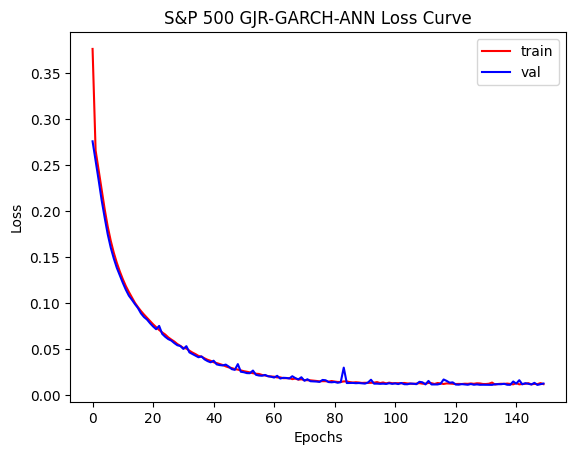

In [401]:
def plot_error(train_loss, val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title("S&P 500 GJR-GARCH-ANN Loss Curve")
    plt.legend(['train', 'val'],loc = 'upper right')
    #plt.savefig('Thesis Document\\KF5 Figures\\NN (5,1,1)\\' + sector + '\\' + sector + ' - NN(5,1,1) Train vs. Validation.png')
    plt.show()
train_error2 = history2.history['loss']
val_error2 = history2.history['val_loss']
plot_error(train_error2, val_error2)

In [ ]:
model = Sequential()
model.add(Dense(1, input_shape=(1,look_back), activation="sigmoid"))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(trainX, trainY, epochs=60, batch_size=1, validation_data = (valX, valY), verbose=1)

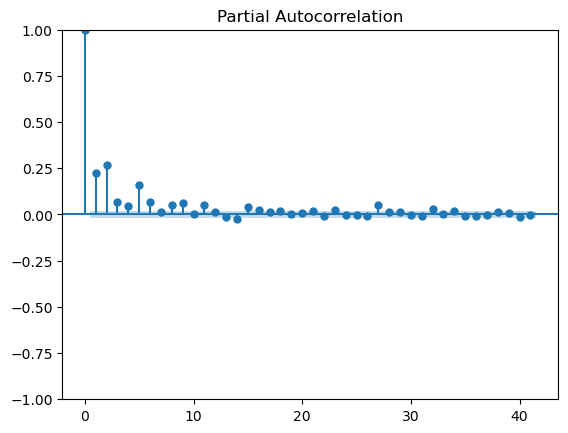

In [11]:
plot_pacf(returns**2)
plt.show()

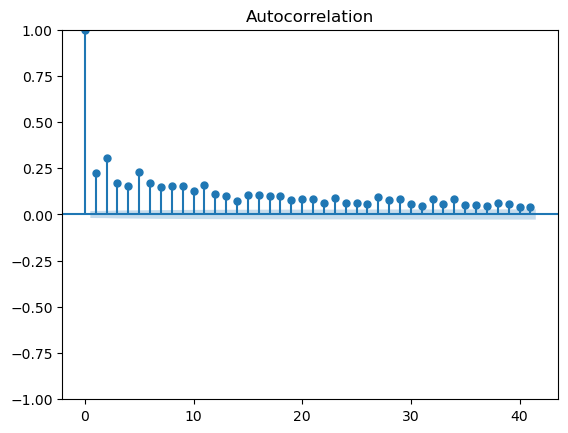

In [18]:
plot_acf(returns**2)
plt.show()

In [22]:
model = arch_model(returns, p=2, q=2)
model_fit = model.fit()
model_fit.summary()


Iteration:      1,   Func. Count:      8,   Neg. LLF: 866239520735786.2
Iteration:      2,   Func. Count:     19,   Neg. LLF: 94679773.2131984
Iteration:      3,   Func. Count:     28,   Neg. LLF: 21174.213058274425
Iteration:      4,   Func. Count:     37,   Neg. LLF: 15733.947560218985
Iteration:      5,   Func. Count:     46,   Neg. LLF: 15611.871620065931
Iteration:      6,   Func. Count:     56,   Neg. LLF: 14294.252873426423
Iteration:      7,   Func. Count:     64,   Neg. LLF: 14447.748956953375
Iteration:      8,   Func. Count:     73,   Neg. LLF: 14144.567355358098
Iteration:      9,   Func. Count:     81,   Neg. LLF: 14104.465755841022
Iteration:     10,   Func. Count:     89,   Neg. LLF: 14101.59257262909
Iteration:     11,   Func. Count:     97,   Neg. LLF: 14099.962107158948
Iteration:     12,   Func. Count:    105,   Neg. LLF: 14098.854104075088
Iteration:     13,   Func. Count:    113,   Neg. LLF: 14094.944315788522
Iteration:     14,   Func. Count:    121,   Neg. LLF: 1

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -14094.1
Distribution:                  Normal   AIC:                           28200.2
Method:            Maximum Likelihood   BIC:                           28243.8
                                        No. Observations:                10591
Date:                Wed, Jan 11 2023   Df Residuals:                    10590
Time:                        00:01:36   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0649  8.132e-03      7.978  1.489e-15 [4.894e-02,8.081e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0364  8.153e-03      4.466  7.986e-06 [2.043e-02,5.239e-02]
alpha[1]       0.0863  2.192e-02      3.939  8.186e-05   [4.338e-02,  0.129]
alpha[2]       0.0908  1.570e-02      5.784  7.294e-09   [6.004e-02,  0.122]
beta[1]        0.1447  8.342e-02      1.734  8.288e-02  [-1.883e-02,  0.308]
beta[2]        0.6480  7.248e-02      8.940  3.883e-19     [  0.506,  0.790]
============================================================================

Covariance estimator: robust
"""

In [336]:
model = arch_model(returns, p=1, o=1, q=1)
model_fit = model.fit()
model_fit.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 1846796584.2132657
Iteration:      2,   Func. Count:     17,   Neg. LLF: 3644120253.0549245
Iteration:      3,   Func. Count:     26,   Neg. LLF: 25501.49767903787
Iteration:      4,   Func. Count:     34,   Neg. LLF: 14296.441231947525
Iteration:      5,   Func. Count:     41,   Neg. LLF: 22445.849724172982
Iteration:      6,   Func. Count:     48,   Neg. LLF: 14004.918532985017
Iteration:      7,   Func. Count:     55,   Neg. LLF: 14006.852427929167
Iteration:      8,   Func. Count:     62,   Neg. LLF: 14008.590226440836
Iteration:      9,   Func. Count:     69,   Neg. LLF: 13970.608255177773
Iteration:     10,   Func. Count:     76,   Neg. LLF: 13969.352003854554
Iteration:     11,   Func. Count:     83,   Neg. LLF: 13969.264469865568
Iteration:     12,   Func. Count:     89,   Neg. LLF: 13969.264071173657
Iteration:     13,   Func. Count:     95,   Neg. LLF: 13969.264069097104
Iteration:     14,   Func. Count:    100,   Neg. LLF

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Constant Mean - GJR-GARCH Model Results                    
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -13969.3
Distribution:                  Normal   AIC:                           27948.5
Method:            Maximum Likelihood   BIC:                           27984.9
                                        No. Observations:                10591
Date:                Sun, Jan 15 2023   Df Residuals:                    10590
Time:                        13:00:26   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0389  7.816e-03      4.977  6.444e-07 [2.359e-02,5.422e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0224  5.280e-03      4.247  2.169e-05 [1.207e-02,3.277e-02]
alpha[1]       0.0238  6.440e-03      3.703  2.131e-04 [1.122e-02,3.647e-02]
gamma[1]       0.1321  2.288e-02      5.774  7.736e-09   [8.727e-02,  0.177]
beta[1]        0.8891  1.651e-02     53.843      0.000     [  0.857,  0.922]
============================================================================

Covariance estimator: robust
"""

In [42]:

model_EGARCH = arch_model(returns, vol='EGARCH' , p = 2 , o = 0 , q = 2)
fitted_EGARCH = model_EGARCH.fit(disp='off')
fitted_EGARCH.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - EGARCH Model Results                     
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -14114.2
Distribution:                  Normal   AIC:                           28240.4
Method:            Maximum Likelihood   BIC:                           28284.0
                                        No. Observations:                10591
Date:                Wed, Jan 11 2023   Df Residuals:                    10590
Time:                        00:29:57   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0663  2.656e-03     24.974 1.161e-137 [6.113e-02,7.155e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0126  4.774e-03      2.649  8.063e-03 [3.291e-03,2.200e-02]
alpha[1]       0.1871  3.896e-02      4.803  1.561e-06     [  0.111,  0.264]
alpha[2]       0.1822  2.877e-02      6.332  2.419e-10     [  0.126,  0.239]
beta[1]        0.2302  9.842e-02      2.339  1.935e-02   [3.728e-02,  0.423]
beta[2]        0.7295  9.759e-02      7.476  7.689e-14     [  0.538,  0.921]
============================================================================

Covariance estimator: robust
"""

[*********************100%***********************]  1 of 1 completed


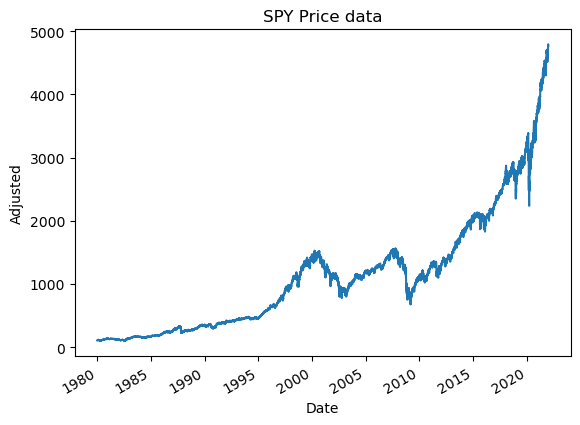

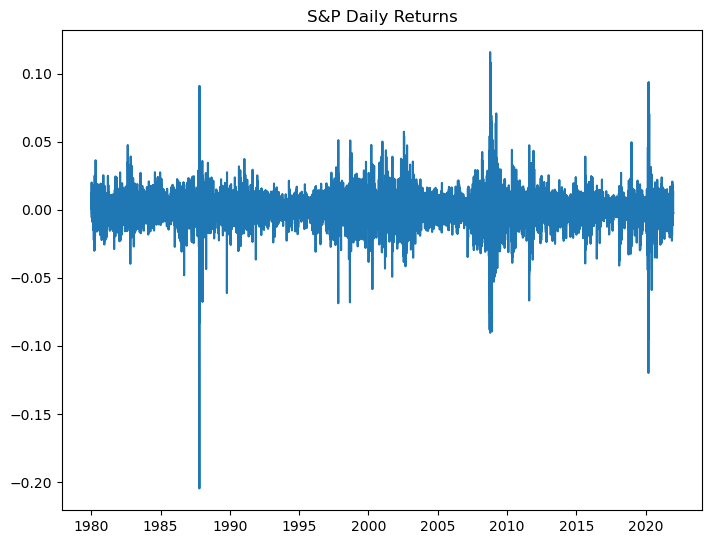

In [47]:
SPY = web.get_data_yahoo("^GSPC", start = "1980-01-01", end = "2022-01-01")

SPY['Adj Close'].plot()
plt.xlabel("Date")
plt.ylabel("Adjusted")
plt.title("SPY Price data")
plt.show()
spy_daily_returns = SPY['Adj Close'].pct_change()
fig = plt.figure()
ax1 = fig.add_axes([1,1,1,1])
ax1.plot(spy_daily_returns)
ax1.set_title("S&P Daily Returns")
plt.show()

/Users/niyanth/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


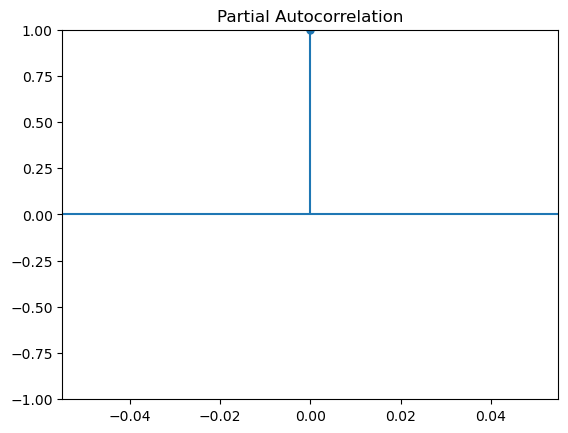

In [8]:
plot_pacf(spy_daily_returns**2)
plt.show()

[*********************100%***********************]  1 of 1 completed


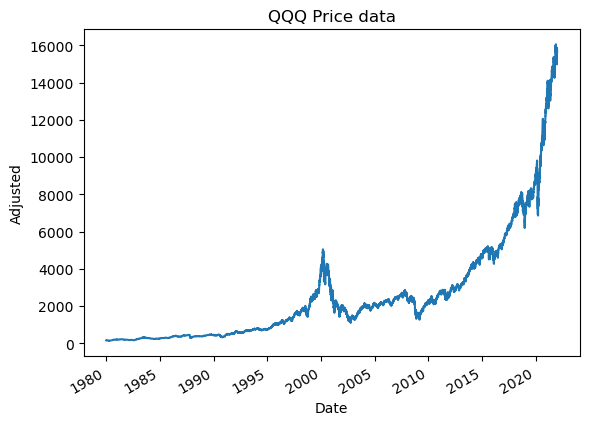

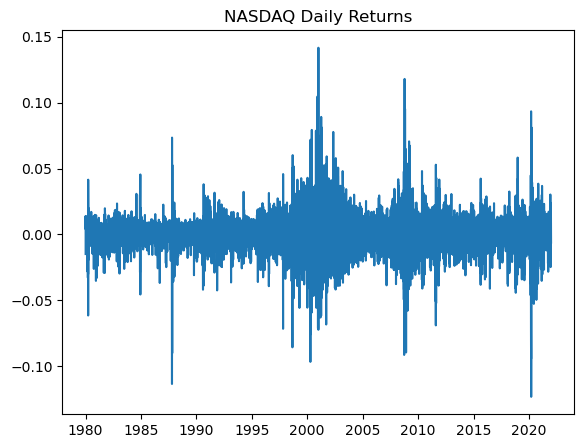

In [81]:
QQQ= web.get_data_yahoo("^IXIC", start = "1980-01-01", end = "2022-01-01")

QQQ['Adj Close'].plot()
plt.xlabel("Date")
plt.ylabel("Adjusted")
plt.title("QQQ Price data")
plt.show()
qqq_daily_returns = QQQ['Adj Close'].pct_change()
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(qqq_daily_returns)
ax1.set_title("NASDAQ Daily Returns")
plt.show()

[*********************100%***********************]  1 of 1 completed


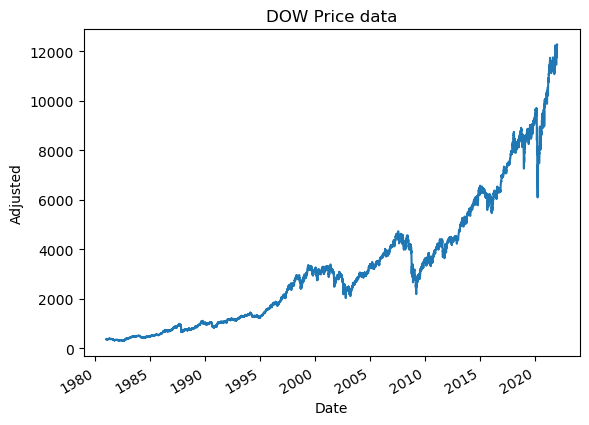

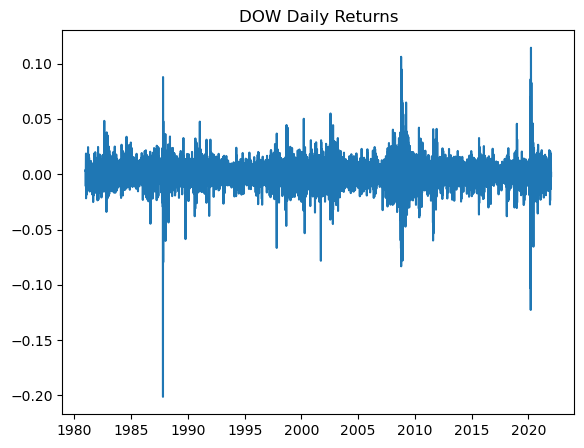

In [82]:
DOW = web.get_data_yahoo("^DJA", start = "1980-01-01", end = "2022-01-01")

DOW['Adj Close'].plot()
plt.xlabel("Date")
plt.ylabel("Adjusted")
plt.title("DOW Price data")
plt.show()
dow_daily_returns = DOW['Adj Close'].pct_change()
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(dow_daily_returns)
ax1.set_title("DOW Daily Returns")
plt.show()

In [75]:
ticker = yf.Ticker('TQQQ')
SPY = ticker.history(interval='1d', start='1980-01-01', end='2022-01-01')
SPY

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2010-02-11 00:00:00-05:00,0.403763,0.431569,0.402471,0.429243,3456000,0.0,0.0,0.0
2010-02-12 00:00:00-05:00,0.417562,0.434722,0.415133,0.431001,8601600,0.0,0.0,0.0
2010-02-16 00:00:00-05:00,0.441131,0.448729,0.434205,0.447695,9619200,0.0,0.0,0.0
2010-02-17 00:00:00-05:00,0.453691,0.455396,0.446868,0.455293,19180800,0.0,0.0,0.0
2010-02-18 00:00:00-05:00,0.454827,0.466663,0.452088,0.463924,38860800,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2021-12-27 00:00:00-05:00,83.113631,86.317006,83.068865,86.247368,62981600,0.0,0.0,0.0
2021-12-28 00:00:00-05:00,86.928826,87.038259,84.576040,85.232635,72412600,0.0,0.0,0.0
2021-12-29 00:00:00-05:00,85.212732,86.048398,83.541406,85.098328,57747400,0.0,0.0,0.0


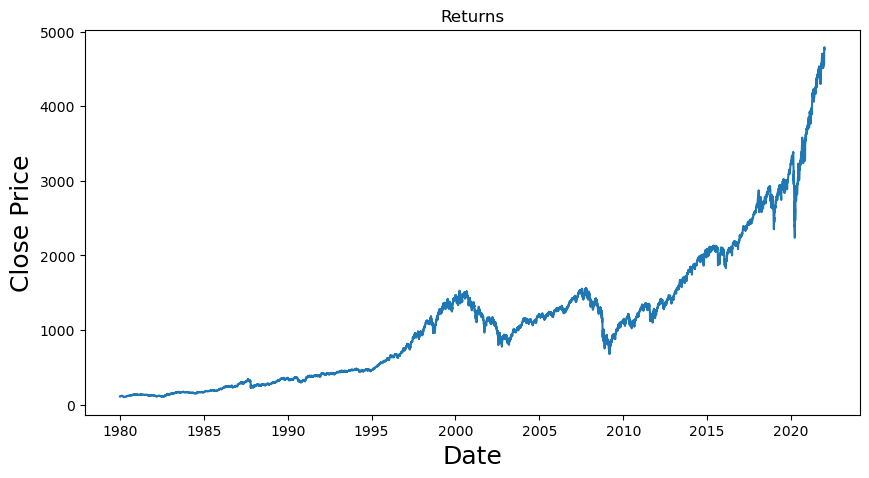

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title('Returns')
plt.plot(SPY['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.show()

In [36]:
import pandas as pd
#if you get an error after executing the code, try adding below. pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import datetime
start = datetime.datetime(1980, 1, 1)
end = datetime.datetime(2022, 1, 1)
SP500 = web.DataReader(['sp500'], 'fred', start, end)

In [32]:
SP500['daily_return'] = (SP500['sp500']/ SP500['sp500'].shift(1)) -1
SP500.dropna(inplace = True)


<AxesSubplot:title={'center':'S&P 500 daily returns'}, xlabel='DATE'>

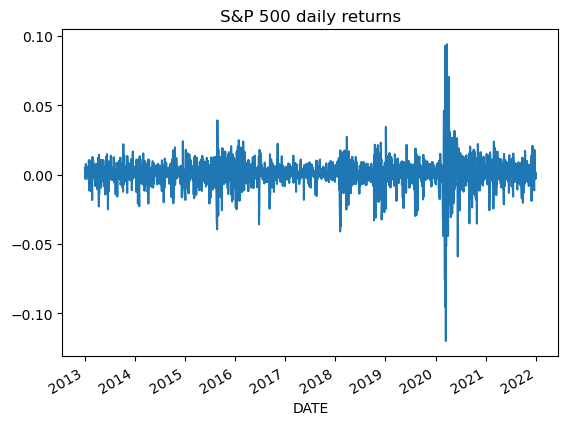

In [33]:
SP500['daily_return'].plot(title='S&P 500 daily returns')
